
# Nombre del Proyecto: Clasificador de Imágenes Piedra, Papel o Tijera con CNN

## Instalación del Dataset y Requerimientos

1. **Extnsiones en VS Code**: 
    -Descarga la extensión de Jupyter en VS code. 


2. **Requerimientos**:
    - Asegúrate de tener Python instalado (versión 3.11 o superior).
    - Instala las siguientes bibliotecas necesarias para el proyecto:
      ```bash
      pip install -r requirements.txt
      ```

3. **Ejecutar**:
    - Click en Run All

## Importación de dependencias

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

# Set random seed for reproducible results
tf.random.set_seed(22)

Python version: 3.11.0
Tensorflow version: 2.19.0
Keras version: 3.9.2


## Cargando el dataset

Se va a descargar el dataset Rock-Paper-Scissors de la colección TensorFlow Datasets. Para eso se descargó el módulo tensorflow_datasets.

tensorflow_datasets define una colección de datasets listos para usar con TensorFlow.

Cada conjunto de datos se define como un tfds.core.DatasetBuilder, que encapsula la lógica para descargar el conjunto de datos y construir un pipeline de entrada, además de contener la documentación del conjunto de datos (versión, divisiones, número de ejemplos, etc.).

In [3]:
# Ver datsets disponibles

tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asimov_dilemmas_auto_val',
 'asimov_dilemmas_scifi_train',
 'asimov_dilemmas_scifi_val',
 'asimov_injury_val',
 'asimov_multimodal_auto_val',
 'asimov_multimodal_manual_val',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 '

In [4]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [5]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw train dataset size: 2520 

Raw test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test dataset size: 372 



In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='tmp\\rock_paper_scissors\\3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-data

In [7]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [9]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 6
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Se reduce el tamaño de las imágenes para acelerar el entrenamiento
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 50
Input image shape (reduced): (50, 50, 3)


Input image size: 50
Input image shape: (50, 50, 3)


In [10]:
# Función para convertir label ID a cadenas de etiquetas.
get_label_name = dataset_info.features['label'].int2str
print(get_label_name(0))
print(get_label_name(1))
print(get_label_name(2))

rock
paper
scissors


## Explorando el dataset

In [11]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

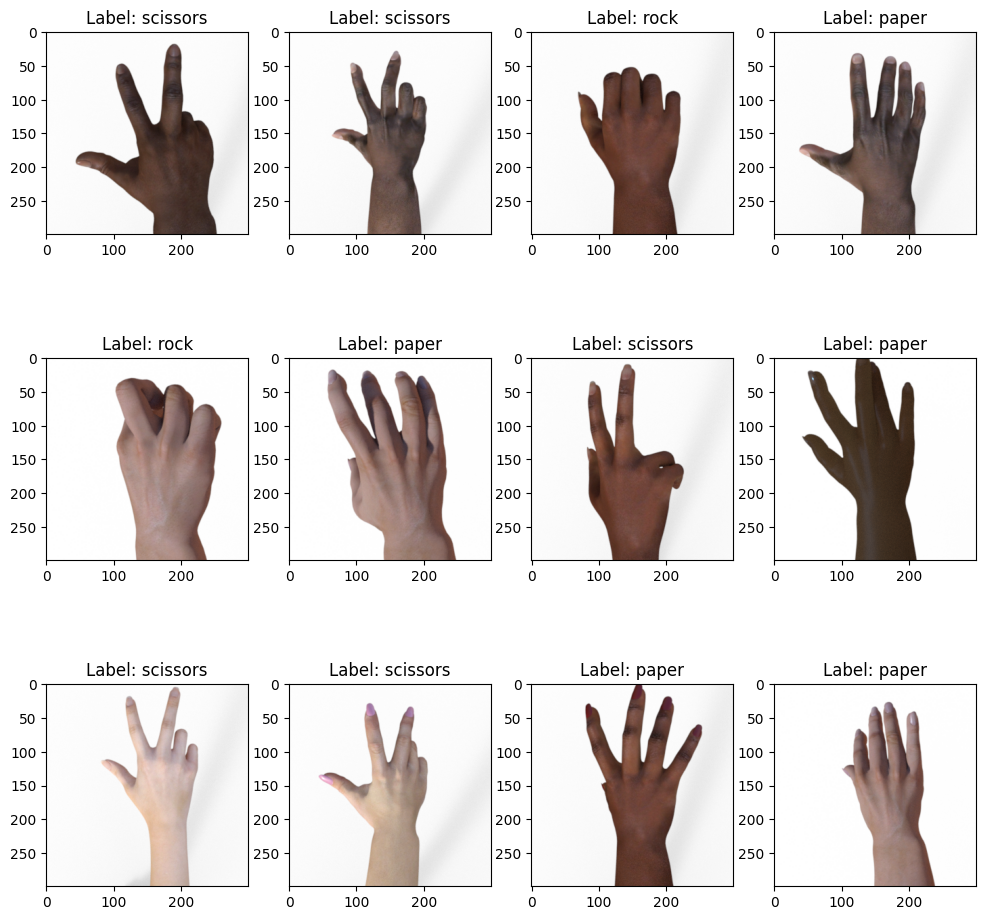

In [12]:
# Explorando las imagenes del dataset. 
preview_dataset(dataset_train_raw)

In [13]:
# Explorando que valores son usados para representar la imagen. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


## Generando el dataset de landmarks
La idea es entrenar al modelo en base a las distancias y posiciones relativas entre los landmarks de las manos

In [14]:
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5,
)

def extract_landmarks_from_dataset(dataset):
    landmarks_list = []
    for image, label in dataset:
        # Convert the image to a numpy array
        image_np = image.numpy()
        # Process the image with MediaPipe Hands
        results = hands.process(image_np)
        if results.multi_hand_landmarks:
            # Extract the first hand's landmarks
            hand_landmarks = results.multi_hand_landmarks[0]
            # Convert landmarks to a list of (x, y, z) tuples
            landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
            landmarks_list.append((landmarks, label))
    # Convert landmarks and labels to numpy arrays for compatibility
    landmarks_array = np.array([np.array(landmarks, dtype=np.float32) for landmarks, label in landmarks_list])
    labels_array = np.array([label.numpy() for landmarks, label in landmarks_list], dtype=np.int64)
    
    return tf.data.Dataset.from_tensor_slices((landmarks_array, labels_array))

# Convert the raw datasets to landmarks datasets
landmarks_train_dataset = extract_landmarks_from_dataset(dataset_train_raw)
landmarks_test_dataset = extract_landmarks_from_dataset(dataset_test_raw)

## Barajado de datos y procesamiento por lotes 

No se quiere que el modelo aprenda algo del orden o la agrupación de las imágenes en el conjunto de datos. Para evitarlo, se va a barajear los ejemplos de entrenamiento. También se va a dividr el conjunto de entrenamiento por lotes para hacer el proceso de entrenamiento más rápido y que consuma menos memoria. 

In [15]:
BATCH_SIZE = 32

dataset_train_augmented_shuffled = landmarks_train_dataset.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.batch(
    batch_size=BATCH_SIZE
)

# Prefetch permitirá que el pipeline de entrada obtenga lotes de forma asincrónica mientras su modelo está entrenando.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = landmarks_test_dataset.batch(BATCH_SIZE)

## Creando el modelo 

In [ ]:
model = tf.keras.models.Sequential()

# Aplanar los resultados para alimentar las capas densas.
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# Capas ocultas
model.add(tf.keras.layers.Dense(units=700, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=500, activation=tf.keras.activations.relu))

# Capa de salida.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compilando el modelo 

In [34]:
# Se usa el optimizador Adam para la optimización del modelo.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [19]:
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 78
validation_steps: 11


In [278]:
!rm -rf tmp/checkpoints
!rm -rf logs

'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [35]:
# Preparando los callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.keras'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [36]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6700 - loss: 0.7031 - val_accuracy: 0.4915 - val_loss: 1.8857
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9058 - loss: 0.2596 - val_accuracy: 0.4773 - val_loss: 2.1368
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9152 - loss: 0.2142 - val_accuracy: 0.6392 - val_loss: 1.7301
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9276 - loss: 0.2022 - val_accuracy: 0.6108 - val_loss: 1.7579
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9240 - loss: 0.1905 - val_accuracy: 0.6108 - val_loss: 1.9727
Epoch 6/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9145 - loss: 0.2080 - val_accuracy: 0.5909 - val_loss: 1.9143
Epoch 7/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9390 - loss: 0.1620 - val_accuracy: 0.6790 - val_loss: 1.3185
Epoch 8/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9373 - loss: 0.1686 - val_accuracy: 0.4915 - val_loss

In [27]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

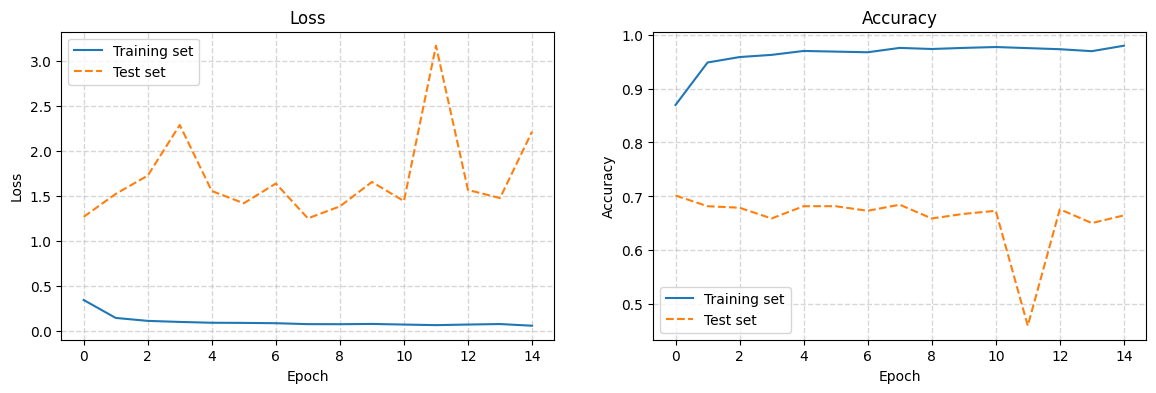

In [28]:
render_training_history(training_history)

## Evaluando la precisión del modelo 

In [283]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9752 - loss: 0.0926
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6890 - loss: 1.1782 


In [284]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.09270402044057846
Training accuracy:  0.9769841432571411


Test loss:  1.2455203533172607
Test accuracy:  0.6666666865348816


## Guardando el modelo 

In [285]:
model_name = 'rock_paper_scissors_mlp.h5'
model.save(model_name, save_format='h5')

## Probando el modelo con imagenes externas

In [34]:
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('rock_paper_scissors_mlp.h5')

In [35]:
import tensorflow as tf
import numpy as np
from PIL import Image

def preprocess_image(image_path, target_size):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Redimensionar la imagen al tamaño esperado
    img = img.resize(target_size)
    # Convertir la imagen a un array de NumPy
    img_array = np.array(img)
    # Normalizar los valores de los píxeles al rango [0, 1]
    img_array = img_array / 255.0
    # Expandir las dimensiones para que sea compatible con el modelo (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [36]:
# Ruta de la imagen a probar
image_path = 'tijera.png'

# Preprocesar la imagen
input_image = preprocess_image(image_path, target_size=(50, 50))  # Cambia (50, 50) si usaste otro tamaño

# Hacer la predicción
predictions = model.predict(input_image)

print('Predicciones:', predictions)

# Obtener la clase con mayor probabilidad
predicted_class = np.argmax(predictions, axis=1)[0]

print(f'Predicción: Clase {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicciones: [[0.03932758 0.0012566  0.9594158 ]]
Predicción: Clase 2


In [37]:
# Convertir la clase predicha a su etiqueta
label_name = get_label_name(predicted_class)
print(f'La imagen pertenece a la clase: {label_name}')

La imagen pertenece a la clase: scissors
